# Introduction to Trancriptomics using Python3 

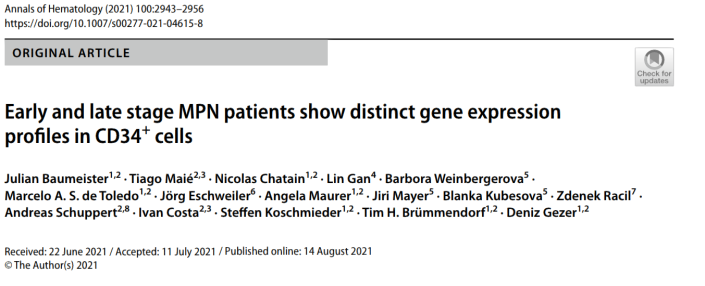

![](img/Header.png)
*By: James S. Nagai, Tiago Maié, Steffen Koschmieder and Ivan G. Costa*

In this course, we will perform gene expression analysis with data from CD34+ cells from MPN patients presented in the above study ([paper](https://link.springer.com/article/10.1007/s00277-021-04615-8)). For this, we will consider previously normalized gene expression data and will perform down-stream analysis such as principal component analysis, clustering, identification of differentially expressed genes and gene ontology analysis. The course is organized into the following sections:
    
1. [HandsOn1-Analysing RNA expression data](#section_1) Here we will perform a dimension reduction using different embbedding algorithms to check the variability presented by our dataset.

2. [HandsOn2-Differential Gene Expression](#section_2) Here we will perform a differential gene expression analysis to identify genes have increase or decrease in expression in MPN samples. 

3. [HandsOn3- Complex Differential Gene Expression](#section_3)Here we will perform a differential gene expression contrasting distinct MPN entities. 

 <a id="section_1"></a>
## 1. Analysing RNA Expression Samples and its Organization

### 1.1.1 Importing the Libraries
Here we need to include all the libraries needed in the analysis process. Note that, you can easily find the documentation and explore each library in depth as you want.

* **Data Science and Mathematics**
   [scipy](https://scipy.org/)
   [numpy](https://numpy.org/)
   [pandas](https://pandas.pydata.org/)
   [sklearn](https://scikit-learn.org/stable/)

* **Visualization**
   [matplotlib](https://matplotlib.org/)
   [seaborn](https://seaborn.pydata.org/)
   
* **RNA Data Organization and DE analysis**
   [anndata](https://anndata.readthedocs.io/en/latest/)
   [diffxpy](https://diffxpy.readthedocs.io/en/latest/)

* **Gene Enrichment Analysis**
   [gprofiler](https://biit.cs.ut.ee/gprofiler/gost)

In [1]:
from scipy.cluster.hierarchy import average, fcluster
from scipy.spatial.distance import pdist,squareform
from scipy import cluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import diffxpy.api as de
import anndata
from gprofiler import GProfiler
sns.set_style("whitegrid")

2022-03-07 14:26:31.163841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 14:26:31.163856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1.2 Data Aquisition and Pre-processing

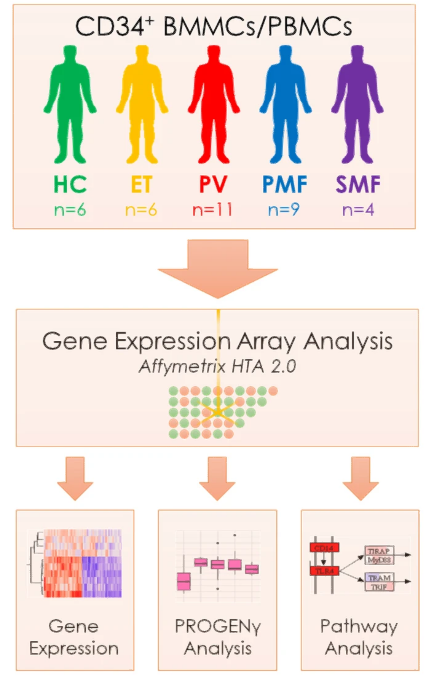

First, we will load a pre-processed gene expression table from our 36 patient/donor samples (gene_exp.csv). Additionally, we will load a metadata table containing patient clinical information including disease entity (HC,ET,PV,PMF and SMF); age, sex, type of treatment and so on. The number of samples per disease entity is shown above. 

In [2]:
gene_exp = pd.read_csv("./data/gene_exp.csv",index_col=0)
clinical = pd.read_csv("./data/clinical.csv",sep=";",index_col=0)

Let's look into the *gene_exp* variable, note that we have genes as rows and samples placed in each column.

In [3]:
gene_exp.head() 

ET1_log2-GEX  ET2_log2-GEX  ET4_log2-GEX  ET7_log2-GEX  \
Gene_Symbol                                                           
AREG            11.813418      8.329595      7.485526      5.769998   
DNTT            14.472263     14.282141     15.104199     12.353701   
EBF1            11.732495     12.111325     13.154767      9.105957   
MPO             16.811077     16.632159     17.258007     17.612614   
P2RY14           7.883733      7.744333      7.429060      7.142824   

             ET8_log2-GEX  ET9_log2-GEX  HC4_log2-GEX  HC5_log2-GEX  \
Gene_Symbol                                                           
AREG             7.110326      9.320978     15.925467     14.669028   
DNTT            14.629142     13.376722     16.725617     13.912437   
EBF1            12.182803     10.895282     14.975238     10.007195   
MPO             16.108587     17.674523     16.707062     17.953611   
P2RY14           8.694308      7.401786      9.839830      8.934115   

             HC6_log2-GEX  HC7_log2-GEX  ...  PV2_log2-GEX  PV3_log2-GEX  \
Gene_Symbol                              ...                               
AREG            15.588651     15.124262  ...      7.777014      8.534371   
DNTT            16.085582     14.534924  ...      7.280988      9.826165   
EBF1            14.292539     12.240903  ...      6.130041      9.076099   
MPO             17.217014     17.323494  ...     14.528053     14.464167   
P2RY14          10.814159      9.479165  ...      5.867091      7.050754   

             PV4_log2-GEX  PV5_log2-GEX  PV7_log2-GEX  PV8_log2-GEX  \
Gene_Symbol                                                           
AREG             8.717595      7.283475      7.600686     11.782606   
DNTT             7.757508      8.912634     13.160187      9.279140   
EBF1             6.691944      8.255010     11.154915      7.537265   
MPO             15.246547     16.603151     16.435069     16.502501   
P2RY14           5.927774      6.701217      7.890482      5.636853   

             PV9_log2-GEX  PV10_log2-GEX  PV11_log2-GEX  PV12_log2-GEX  
Gene_Symbol                                                             
AREG             7.977295       7.277823      10.955110       8.795819  
DNTT             7.123812      13.123779       9.395824      10.851799  
EBF1             6.128455      11.496114       6.852756       7.716238  
MPO             11.115381      16.892112      13.344429      17.839136  
P2RY14           6.465393       8.130758       6.723528       7.545549  

[5 rows x 36 columns]

In the same manner, here we take a look into the *clinical* data. Each column represents each sample and the rows represent each characteristic related do the sample/donor.

In [4]:
clinical.head() 

ET1       ET2        ET4       ET7              ET8  \
Patient                                                                        
Age [y]                   41        53         52        47               19   
Sex                        F         F          M         M                M   
Diagnosis                 ET        ET         ET        ET               ET   
Driver mutation    JAK2V617F  CALRins5  CALRdel52  MPLW515L  triple-negative   
Allele burden [%]         14       NaN         14        24                0   

                               ET9        PV1        PV2        PV3  \
Patient                                                               
Age [y]                         33         58         76         68   
Sex                              F          M          M          M   
Diagnosis                       ET         PV         PV         PV   
Driver mutation    triple-negative  JAK2V617F  JAK2V617F  JAK2V617F   
Allele burden [%]                0         89         86         94   

                         PV4  ...       SMF1       SMF2       SMF3       SMF5  \
Patient                       ...                                               
Age [y]                   65  ...         71         43         56         68   
Sex                        F  ...          F          F          F          F   
Diagnosis                 PV  ...        SMF        SMF        SMF        SMF   
Driver mutation    JAK2V617F  ...  JAK2V617F  JAK2V617F  CALRdel52  JAK2V617F   
Allele burden [%]         30  ...        NaN        NaN         51        NaN   

                   HC4  HC5  HC6  HC7  HC8  HC9  
Patient                                          
Age [y]             29   27   28   28   32   27  
Sex                  F    F    M    M    F    F  
Diagnosis           HC   HC   HC   HC   HC   HC  
Driver mutation    NaN  NaN  NaN  NaN  NaN  NaN  
Allele burden [%]  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 36 columns]

Now, we can check the distribuition of the gene expression in each collected sample.

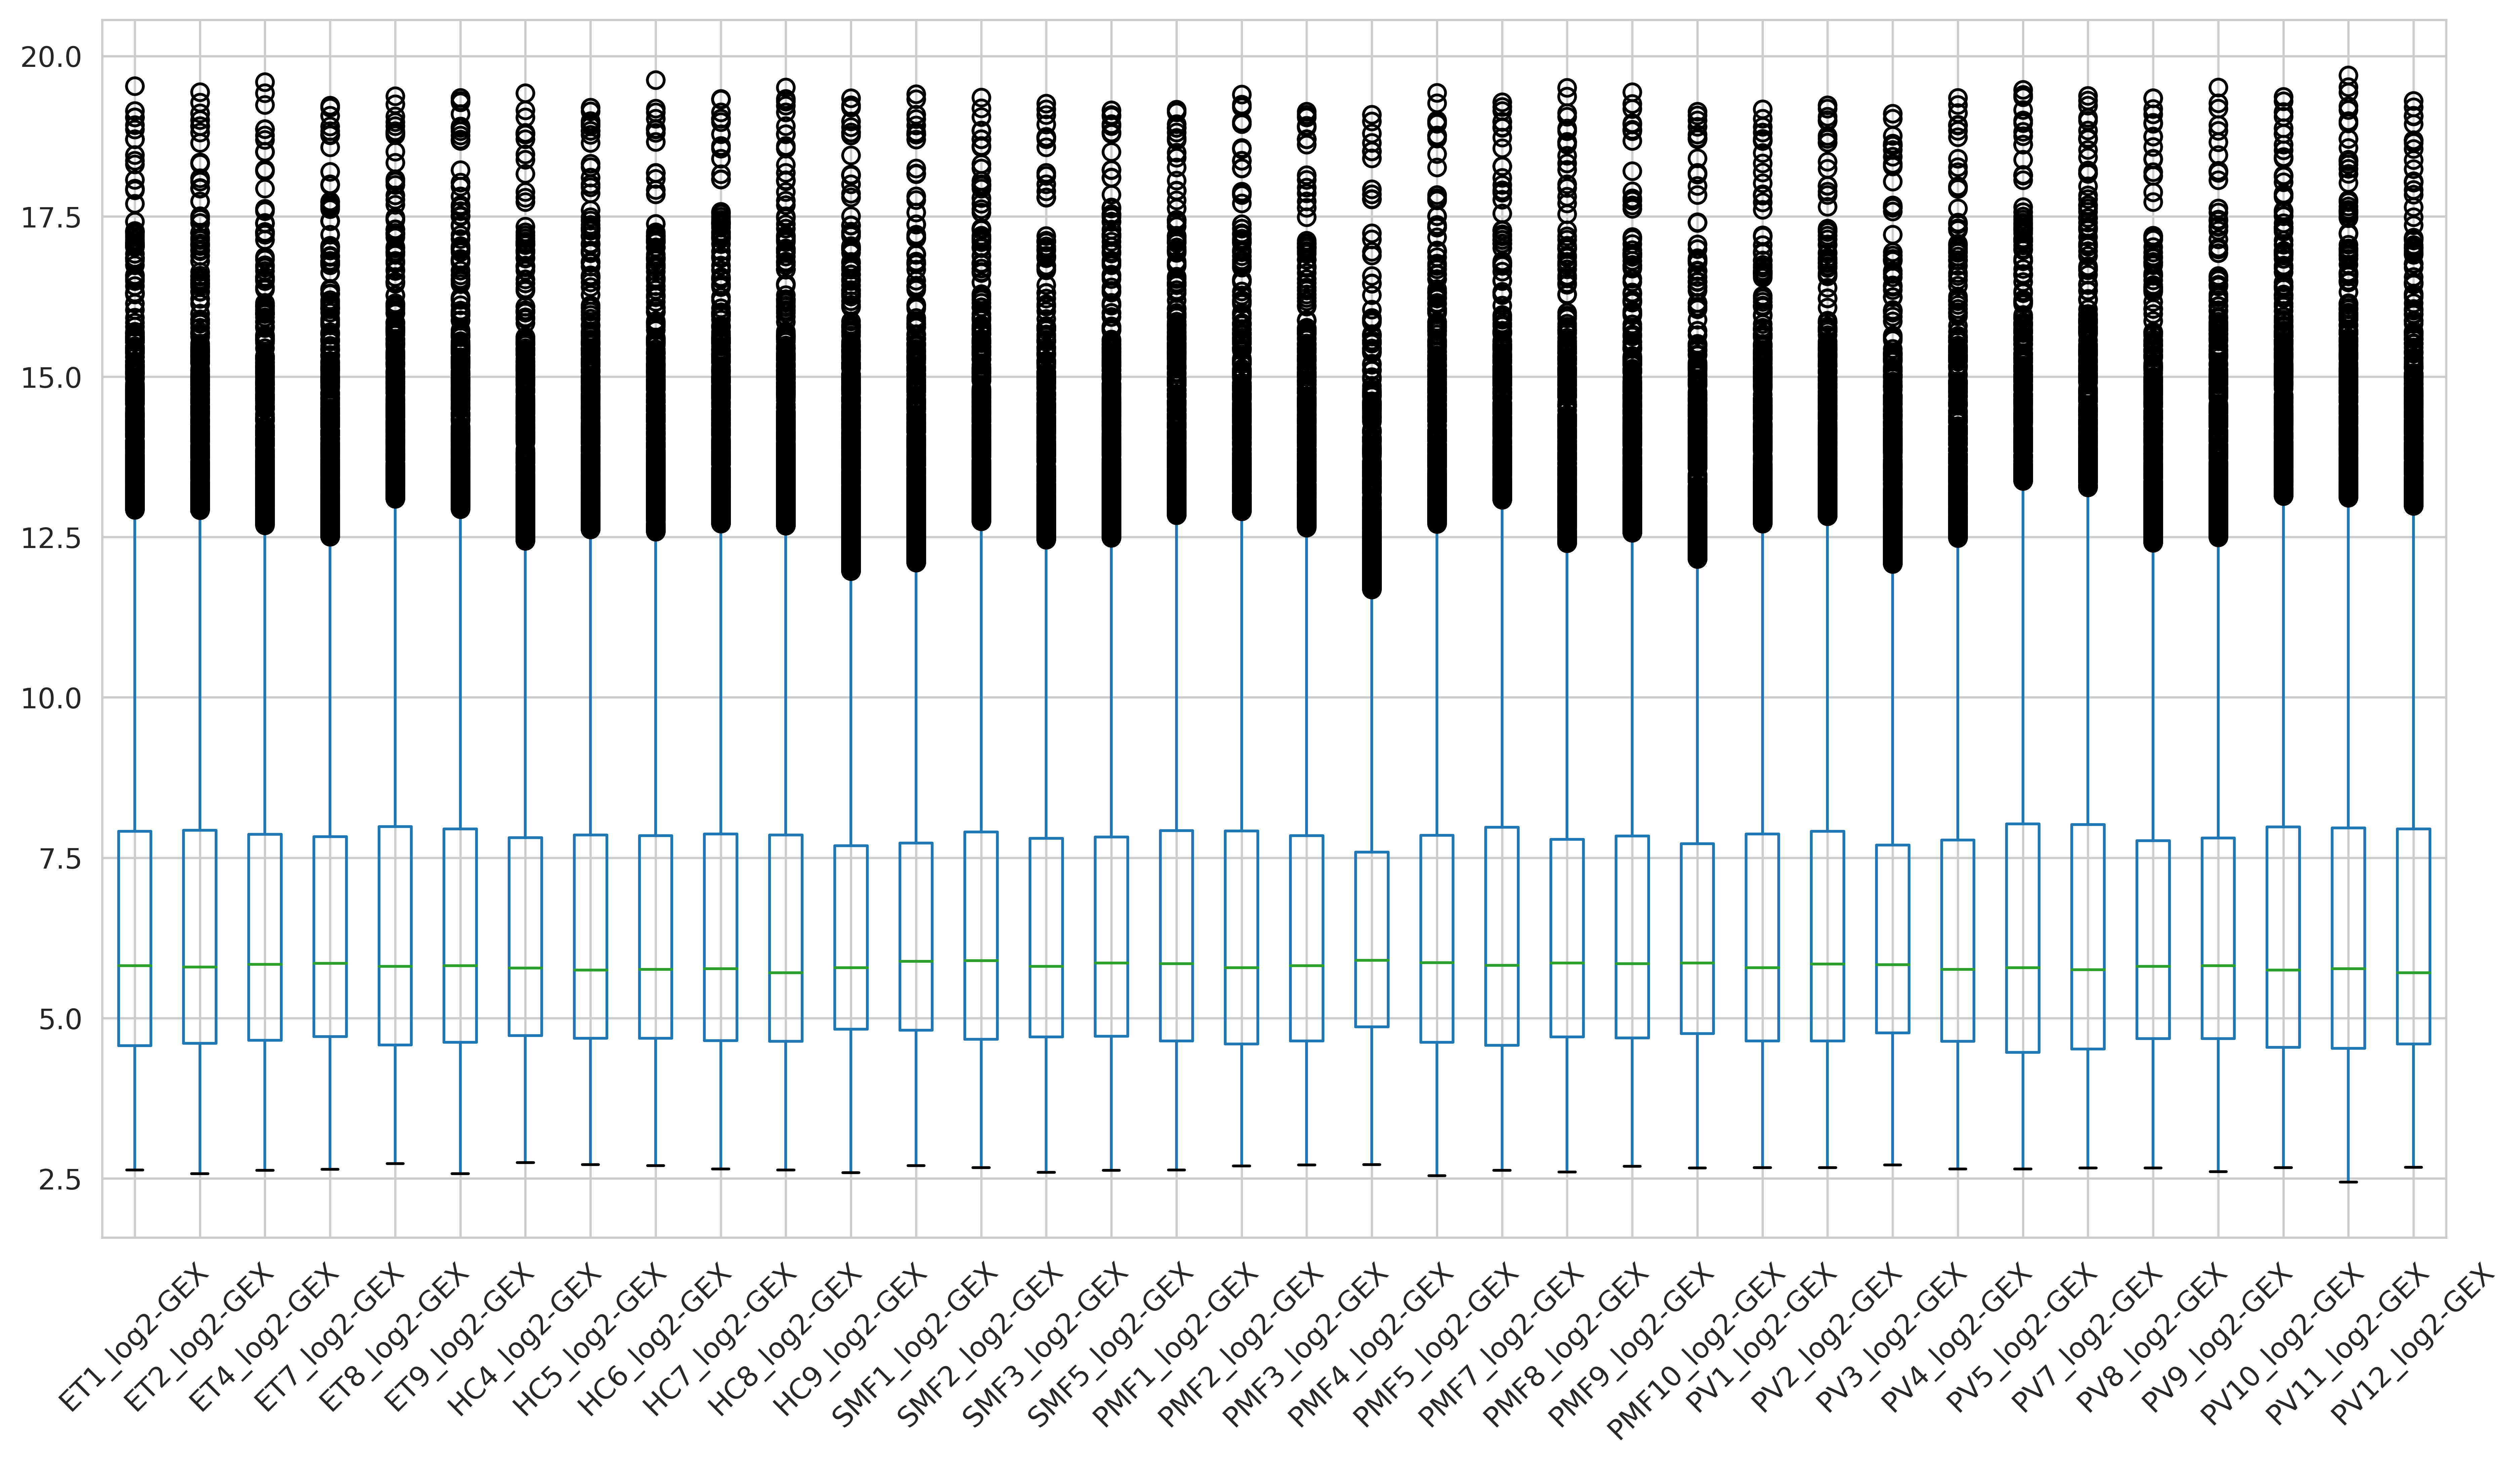

In [5]:
plt.figure(figsize=(15,8),dpi=600)
gene_exp.boxplot()
l=plt.xticks(rotation=45)

We will next match the gene expression with the clinical data, but changing the collumn names to the IDs and check the distribution of the diagnosis daata. 

In [1]:
selection = []             # Step1: We create a list containing all samples of interest
for i in gene_exp.columns: # Step2: Iterate over the gene expression samples
    pos = i.find("_")      # Step3: Find the '_' position
    selection.append(i[:pos])

NameError: name 'gene_exp' is not defined

We we will sort the clinical data to follow the same organization of samples as in the gene expression file. 


<AxesSubplot:xlabel='Diagnosis'>

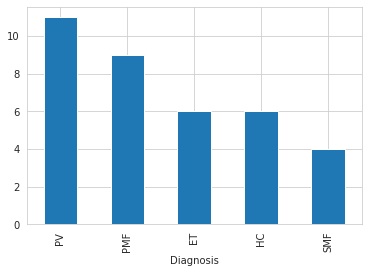

In [7]:
# Transposing the clinical table
clinical = clinical.T
# Organize our data using the selection list
clinical=clinical.loc[selection,]
# Changing the 'Diagnosis' columns to categorical data
clinical['Diagnosis'] = clinical['Diagnosis'].astype('category')
# Using pandas to plot small things like the Diagnosis distribuition
clinical.value_counts('Diagnosis').plot(kind='bar')

### 1.3 Building the AnnData

To handle large data processing and also allow a structured way to organize the gene expression data, we will transform our data using an AnnData object. In the AnnData format, we will find some key fields as described below.


**.X**: The gene expression matrix with samples x features (donors X genes).

**.var**: Represents the characteristics of our features (genes). This is useful to store gene IDs from other databases descriptors of genes such as ENSEMBL or ENTREZ IDs. 

**.obs**: Metadata associated to each sample (donors). Here, we will store clinical data. 

![](img/anndata.png)

First we need to make sure the clinical index is equal to our gene expression columns

In [8]:
clinical.reset_index(inplace=True)
clinical.index = gene_exp.columns

Now, we can create an AnnData object providing the gene expression table as X and the clinical data as obs. 

In [2]:
data = anndata.AnnData(
    X=gene_exp.T,                           # Transposed gene expression
    var=pd.DataFrame(index=gene_exp.index), # Dataframe with gene names
    obs=clinical                            # Clinical Data
)

NameError: name 'anndata' is not defined

### 1.4 Dimension Reduction

A common first task is to perform dimension reduction and inspect potential groups of (MPN) samples. Here, we will consider the linear dimension reduction method PCA, which was discussed in our lecture.

<center><img src="img/Pca.png" alt="pca" /></center>

**PCA documentation:** https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [10]:
# Here, we will create a PCA object using as input the number of desired components
PCAembb = PCA(n_components = 3) 
# Now, we can use our gene expression matrix to compute our PCA
X_transformed = PCAembb.fit_transform(data.X)

Next, we will plot the results using a scatter plot. The package seaborn provides nice aesthetics for this. 

**seaborn scatter plot:** https://seaborn.pydata.org/generated/seaborn.scatterplot.html

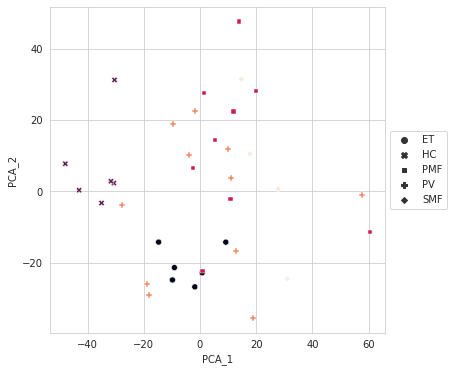

In [11]:
# Now that we have our PCA done, we can try to visualize our PCA in a plot 
label1 = 'PCA_1' # Here we will define labels respective to our PCs
label2 = 'PCA_2'
# Next, we can store our PCs in the obs, can you remember what we have within obs in our AnnData object?
data.obs[label1] = X_transformed[:,0]
data.obs[label2] = X_transformed[:,1]
plt.figure(figsize=(6,6))
sns.scatterplot(x=label1,y=label2,
                c=data.obs['Diagnosis'].cat.codes, # getting the codes instead the Diagnosis label
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 1.5 Adding the text over the samples

We can further enrich the previous plot by adding text over the dots (name of samples). 

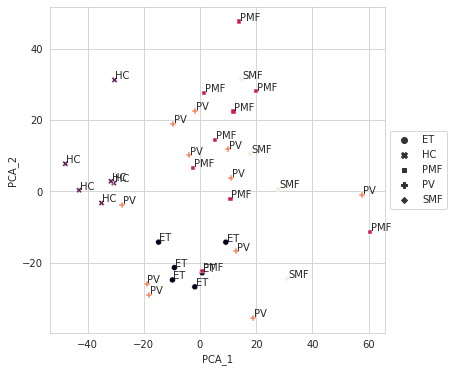

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=label1,y=label2,
                c=data.obs['Diagnosis'].cat.codes,
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
# Here we will add a label to each point from the PCA
for i in range(data.obs.shape[0]):
    plt.text(x=data.obs[label1][i]+0.3,
         y=data.obs[label2][i]+0.3,
         s=data.obs.Diagnosis[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### 1.6 Variance explained by each component

In [13]:
PCAembb.explained_variance_ratio_

array([0.19353665, 0.13592319, 0.09707933], dtype=float32)

In [14]:
# The line below allows you to save your anndata, but you don't need to run it now
# anndata.AnnData.write(data,'data/cd34.h5ad')

### 1.7 Exercices

#### 1.7.1 Color the PCA using the clinical metadata Sex

#### 1.7.2 Change the size of each dot using the Allele Burden clinical metadata

#### 1.7.3 Check if driver mutations groups together in the PCA

#### 1.7.4 Can you try to plot PC 2 vs. PC3 ? 

<a id="section_2"></a>
## 2. Differential Gene Expression Simple Case: Healthy vs Diseased

In this section, we will perform differential expression analysis. First, we will explore genes with change in expression in healthy and diseased (MPNs). 

### 2.1 Defining our comparisons

As an initial step, we need to define our comparison. We will create a new variable, "condition", for this. 

In [3]:
# Assing to condition True if Diagnosis is HC False otherwise
data.obs['condition'] = data.obs['Diagnosis']!='HC' 
# Change bool to int
data.obs['condition'] = data.obs['condition'].astype('int')

NameError: name 'data' is not defined

In [16]:
data.obs.head()

Patient      index Age [y] Sex Diagnosis  Driver mutation Allele burden [%]  \
ET1_log2-GEX   ET1      41   F        ET        JAK2V617F                14   
ET2_log2-GEX   ET2      53   F        ET         CALRins5               NaN   
ET4_log2-GEX   ET4      52   M        ET        CALRdel52                14   
ET7_log2-GEX   ET7      47   M        ET         MPLW515L                24   
ET8_log2-GEX   ET8      19   M        ET  triple-negative                 0   

Patient      Source         Treatment Karyotype      PCA_1      PCA_2  \
ET1_log2-GEX     BM       Ruxolitinib     46,XX  -1.831224 -26.796579   
ET2_log2-GEX     BM         untreated     46,XX -14.710412 -14.254065   
ET4_log2-GEX     BM    peg Interferon     46,XY   0.805865 -22.861017   
ET7_log2-GEX     BM  Hydroxycarbamide       NaN   9.196145 -14.268329   
ET8_log2-GEX     BM         untreated       NaN  -9.789896 -24.862230   

Patient       condition  
ET1_log2-GEX          1  
ET2_log2-GEX          1  
ET4_log2-GEX          1  
ET7_log2-GEX          1  
ET8_log2-GEX          1

### 2.2 Performing differential analysis with a t-test 

Next, we perform a t-test to find genes with increased (or decreased) expression when comparing these two groups of donors. 

In [17]:
test = de.test.t_test(
    data=data,           # AnnData
    grouping="condition" # .obs column used to do the analysis
)

#### 2.2.1 Show the genes in a volcano plot

We can do an initial check of the results by using a volcano plot. This plot shows the change in expression (FC) in the x-axis vs. the significance of this change (p-value) in the y-axis. Positive FC indicates genes that have higher expression in the disease samples rather than in the control samples. Negative FC indicates genes that have a higher expression in the control samples, rather than in the disease samples.

<Figure size 576x576 with 0 Axes>

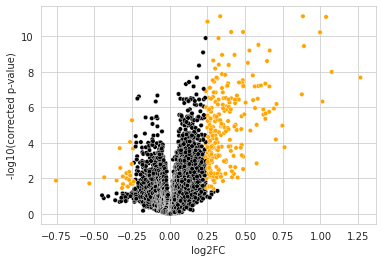

In [18]:
plt.figure(figsize=(8,8))
test.plot_volcano(corrected_pval=True, min_fc=1.18, alpha=0.05, size=20) 
plt.show()

### 2.3 Exploring the results

To further our analysis, we will get the test output table with the results for the differential analysis.  We will look for down- or up-regulated genes in the disease. 

In [19]:
result = test.summary() # Getting the test result in a pandas df
result.head()

gene      pval      qval    log2fc       mean  zero_mean  zero_variance
0    AREG  0.000890  0.013281 -0.753875   9.454930      False          False
1    DNTT  0.001531  0.019040 -0.533574  10.555662      False          False
2    EBF1  0.033235  0.129498 -0.437239   9.145275      False          False
3     MPO  0.000001  0.000090 -0.262981  15.020545      False          False
4  P2RY14  0.000470  0.008660 -0.434544   7.300814      False          False

In [20]:
result.tail()

gene          pval          qval    log2fc       mean  zero_mean  \
25882   LGMN  5.136033e-09  1.176606e-06  0.691226   9.505555      False   
25883  VCAM1  1.691905e-09  4.716628e-07  1.013646   7.595639      False   
25884  CD163  9.371790e-16  8.086918e-12  1.037461   7.781432      False   
25885   FGL2  2.586023e-06  1.747895e-04  0.761476  10.465884      False   
25886  TIMD4  2.450861e-11  2.114848e-08  1.265102   7.275786      False   

       zero_variance  
25882          False  
25883          False  
25884          False  
25885          False  
25886          False

Next we will select the DE genes such that the corrected p-values and the change in expression obey some thresholds. In this case we want genes that appear to be significantly expressed (qvalue < 0.05) and with a high change in expression values (|log2fc| > 0.5).

In [21]:
highlight = np.bitwise_and(result['qval'] <= 0.05,np.abs(result['log2fc']) > 0.5)

To see how those DE-genes are expressed in our dataset, we will make a heatmap using seaborn.

In [22]:
reshighlights = test.summary().loc[highlight,]

In [23]:
reshighlights = reshighlights.sort_values(by='log2fc',ascending=False)

Showing the most under- and over-expressed genes in our comparisons.

In [24]:
genes = [reshighlights['gene'].iloc[-1],reshighlights['gene'].iloc[1]]

In [25]:
intgenes=data[:,genes].to_df()
intgenes['Diagnosis'] = data.obs['Diagnosis']


In [26]:
intgenes.head()

Gene_Symbol        AREG       SPIC Diagnosis
ET1_log2-GEX  11.813418   9.827242        ET
ET2_log2-GEX   8.329596   6.518610        ET
ET4_log2-GEX   7.485526  10.855192        ET
ET7_log2-GEX   5.769999   9.516830        ET
ET8_log2-GEX   7.110326   7.987140        ET

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/boxplot.py:394: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = boxplot(


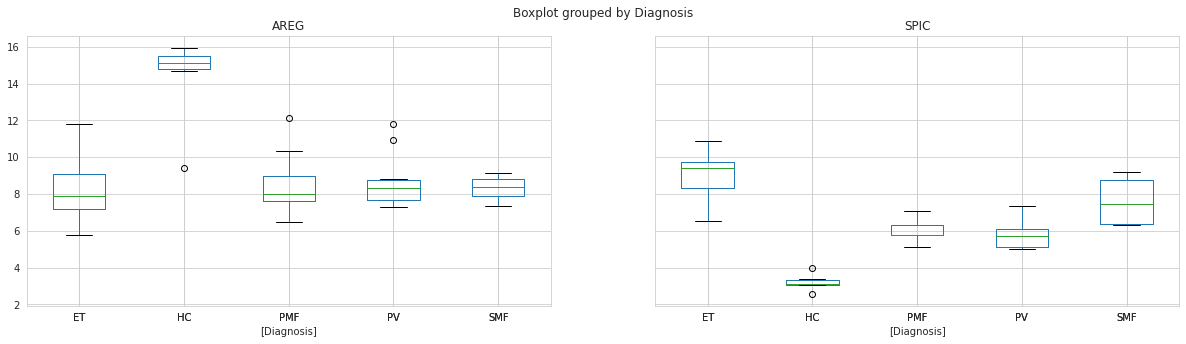

In [27]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
intgenes.boxplot(by='Diagnosis',ax=ax)
plt.show()

Note that, initially, we will use the **euclidean distance** with the **average clustering** method

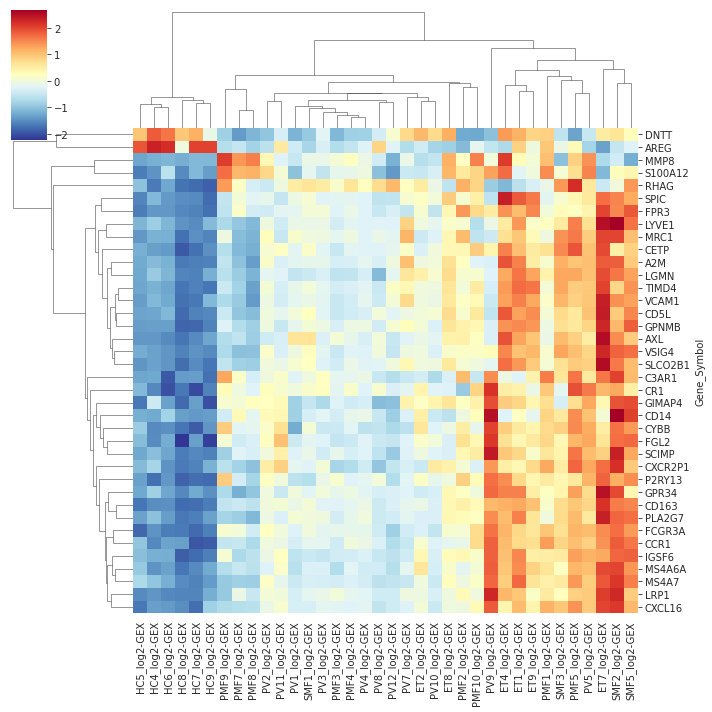

In [28]:
sns.clustermap(data[:, reshighlights['gene']].to_df().T,
               metric='euclidean',   # Distance
               method='average',     # Clustering method
               cmap=plt.cm.RdYlBu_r, # Color Pallete
               z_score=0             # Normalization axis 0 rows 1 columns
               )

### 2.4 Gene Ontology enrichment analysis

We will now check if DE up-regulated genes are associated with particular gene ontology terms using a Fischer's exact test, as implemented by g:profiler. 

In [29]:
gp = GProfiler(return_dataframe=True) # creating a gprofiler object
up_regulated=reshighlights['gene'][reshighlights['log2fc']>0].tolist()
enrich = gp.profile(organism='hsapiens',
            query=up_regulated,
            sources=["GO:MF","GO:CC","GO:BP"]) # querying g:profiler, providing up-regulated genes as input

# we can check the results
enrich.head()

source      native                                          name  \
0  GO:BP  GO:0002376                         immune system process   
1  GO:BP  GO:0002682           regulation of immune system process   
2  GO:BP  GO:0006952                              defense response   
3  GO:BP  GO:0006955                               immune response   
4  GO:BP  GO:0002684  positive regulation of immune system process   

        p_value  significant  \
0  3.903718e-14         True   
1  1.137826e-10         True   
2  2.097930e-09         True   
3  1.414288e-08         True   
4  1.822126e-08         True   

                                         description  term_size  query_size  \
0  "Any process involved in the development or fu...       2748          31   
1  "Any process that modulates the frequency, rat...       1423          31   
2  "Reactions, triggered in response to the prese...       1687          31   
3  "Any immune system process that functions in t...       1888          31   
4  "Any process that activates or increases the f...        920          31   

   intersection_size  effective_domain_size  precision    recall    query  \
0                 25                  21029   0.806452  0.009098  query_1   
1                 18                  21029   0.580645  0.012649  query_1   
2                 18                  21029   0.580645  0.010670  query_1   
3                 18                  21029   0.580645  0.009534  query_1   
4                 14                  21029   0.451613  0.015217  query_1   

                                parents  
0                          [GO:0008150]  
1              [GO:0002376, GO:0050789]  
2                          [GO:0006950]  
3              [GO:0002376, GO:0050896]  
4  [GO:0002376, GO:0002682, GO:0048518]

 We can now plot the results as a bar plot. The siginificance is shown as a -log(10) of the p-value, where higher values indicate a higher significance. 

<AxesSubplot:xlabel='NES', ylabel='name'>

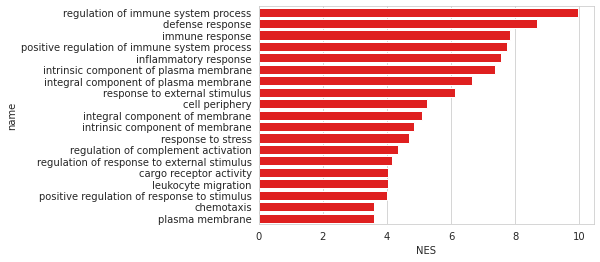

In [30]:
enrich['NES'] = -np.log10(enrich['p_value'])
enrich.sort_index(axis=0,level='NES',inplace=True)
sns.barplot(x='NES',y='name',data=enrich.iloc[1:20,],color='red')  

### 2.5 Exercices

#### 2.5.1 Change the metric and method parameters in the clustermap function. For example, you can try using a distinct distance metric or a distinct clustering method. 



#### 2.5.2 Perform the GO analysis on down-regulated genes upon disease.  


<a id="section_3"></a>
# 3. Differential Gene Expression: Healthy vs individual MPN disease entities 

We can now repeat the analysis from section 2, but now focusing on the comparison of HC vs. MPN entities (PV, ET, PMF and SMF). As the code here is similar as in section 2, we will not describe everything in detail. 

In [4]:
test = de.test.pairwise(
    data=data,            # AnnData
    grouping="Diagnosis", # Diagnosis column
    test="t_test",        # Type of the test
    lazy=False,           # Computing mode
    noise_model=None)

NameError: name 'de' is not defined

In [32]:
pmf = test.summary_pairs(groups0=['HC'],groups1=['PMF']) #results of the comparison HC vs. PMF

In [33]:
pmfhighlight = np.bitwise_and(pmf['qval'] <= 0.05, np.abs(pmf['log2fc']) > 0.25)

<Figure size 576x576 with 0 Axes>

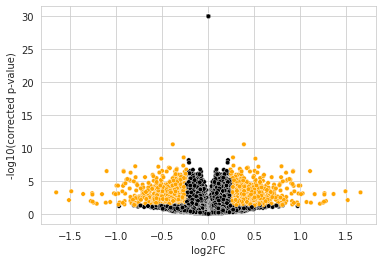

In [34]:
plt.figure(figsize=(8,8))
test.plot_volcano(corrected_pval=True, min_fc=1.18, alpha=0.05, size=20) 
plt.show()

In [35]:
pmfres = pmf.loc[pmfhighlight,]

In [36]:
pmfres.head()

gene      pval      qval    log2fc       mean
0    AREG  0.000466  0.013414 -0.753022   9.454929
1    DNTT  0.000076  0.005903 -0.935131  10.555661
3     MPO  0.000039  0.004329 -0.500404  15.020547
4  P2RY14  0.000224  0.009724 -0.489927   7.300814
6   RELL1  0.000014  0.003103 -0.339428   8.770914

In [37]:
selsamples = data.obs['Diagnosis'].isin(['HC','PMF'])

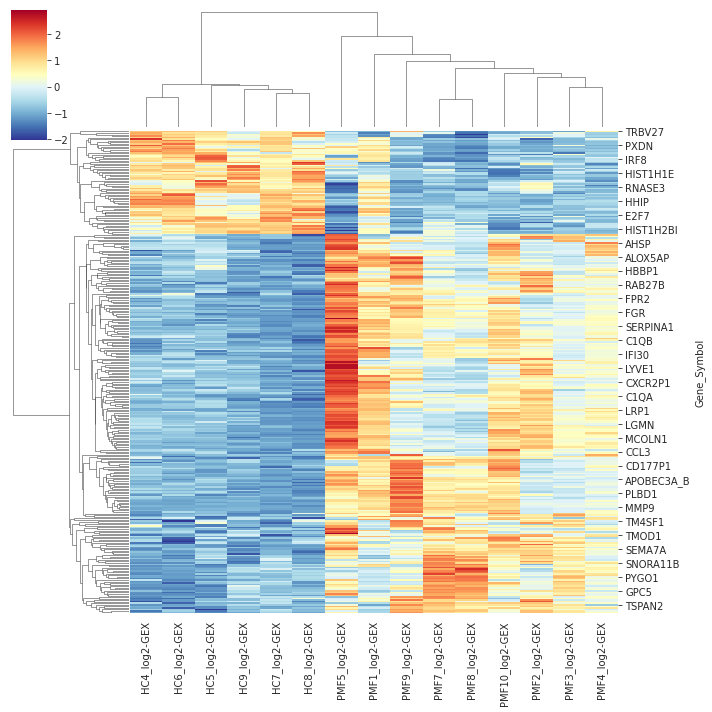

In [38]:
sns.clustermap(data[selsamples, pmfres['gene']].to_df().T,
               metric='euclidean',
               method='average',
               cmap=plt.cm.RdYlBu_r,
               z_score=0)

In [39]:
pmfres = pmfres.sort_values(axis=0,by='log2fc',ascending=False)

In [40]:
pmfres

gene          pval      qval    log2fc       mean
25886  TIMD4  2.063779e-04  0.009324  1.007573   7.275785
25849   MMP8  1.029626e-05  0.002665  0.982487   6.257096
25876   FPR3  1.113027e-05  0.002795  0.927362   6.180520
25878   SPIC  5.924967e-08  0.000446  0.921988   6.156927
25884  CD163  4.482509e-06  0.002072  0.901683   7.781431
...      ...           ...       ...       ...        ...
3        MPO  3.893985e-05  0.004329 -0.500404  15.020547
71     ELANE  3.261089e-03  0.036929 -0.513837   7.397982
13      BLNK  4.968121e-03  0.046530 -0.525086   8.652365
0       AREG  4.658408e-04  0.013414 -0.753022   9.454929
1       DNTT  7.596242e-05  0.005903 -0.935131  10.555661

[312 rows x 5 columns]

<AxesSubplot:xlabel='NES', ylabel='name'>

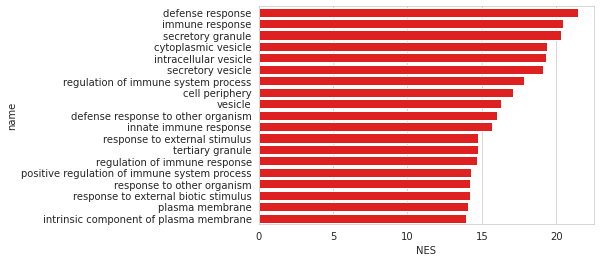

In [41]:
gp = GProfiler(return_dataframe=True)
enrich = gp.profile(organism='hsapiens',
            query=pmfres['gene'][0:100].to_list(),
            sources=["GO:MF","GO:CC","GO:BP"])
enrich['NES'] = -np.log10(enrich['p_value'])
enrich.sort_index(axis=0,level='NES',inplace=True)
sns.barplot(x='NES',y='name',data=enrich.iloc[1:20,],color='red')  

### 3.1 Do the remaining comparisons presented by the paper

#### 3.1.1 Perform DE, clustering and GO analysis for other entity comparirsons (HC vs. ET, HC vs. PV, ...). 